In [1]:
import sys
import os
import importlib
import random
from itertools import combinations
import glob

import numpy as np
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import mdtraj as md
import MDAnalysis as mda

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
pplt.load_cmaps()

In [4]:
%config InlineBackend.figure_format = "retina"

# Gating charge

In [5]:
topfile = "/project/dinner/scguo/ci-vsd/models/MD-clustering-center/civsd.psf"
u = mda.Universe(topfile, "/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.3.dcd")

In [6]:
def compute_displacement_charge(u, not_ions, ions):
    Lz = u.dimensions[2] # length of box
    q = 0
    # protein, lipid, water
    # for atom in u.select_atoms("not segid ION"):
    for atom in not_ions:
        q += atom.charge * (atom.position[2] + 0.5 * Lz) / Lz
    # ions, use unwrapped coordinates
    # for atom in u.select_atoms("segid ION"):
    for atom in ions:
        z = atom.position[2]
        if z > 0:
            z -= Lz
        q += atom.charge * (z + 1.0 * Lz) / Lz
    return q

In [7]:
def compute_displacement_charge_sel(u, sel):
    Lz = u.dimensions[2] # length of box
    q = 0
    # protein, lipid, water
    for atom in sel:
        q += atom.charge * (atom.position[2] + 0.5 * Lz) / Lz
    return q

In [8]:
sel = u.select_atoms("protein and resid 217 to 233 and backbone")

s4q = np.empty(len(u.trajectory))
for i, _ in enumerate(u.trajectory):
    s4q[i] = compute_displacement_charge_sel(u, sel)

In [9]:
for a in sel:
    print(a)

<Atom 1767: N of type NH1 of resname ARG, resid 217 and segid A>
<Atom 1769: CA of type CT1 of resname ARG, resid 217 and segid A>
<Atom 1789: C of type C of resname ARG, resid 217 and segid A>
<Atom 1790: O of type O of resname ARG, resid 217 and segid A>
<Atom 1791: N of type NH1 of resname LEU, resid 218 and segid A>
<Atom 1793: CA of type CT1 of resname LEU, resid 218 and segid A>
<Atom 1808: C of type C of resname LEU, resid 218 and segid A>
<Atom 1809: O of type O of resname LEU, resid 218 and segid A>
<Atom 1810: N of type NH1 of resname VAL, resid 219 and segid A>
<Atom 1812: CA of type CT1 of resname VAL, resid 219 and segid A>
<Atom 1824: C of type C of resname VAL, resid 219 and segid A>
<Atom 1825: O of type O of resname VAL, resid 219 and segid A>
<Atom 1826: N of type NH1 of resname VAL, resid 220 and segid A>
<Atom 1828: CA of type CT1 of resname VAL, resid 220 and segid A>
<Atom 1840: C of type C of resname VAL, resid 220 and segid A>
<Atom 1841: O of type O of resname 

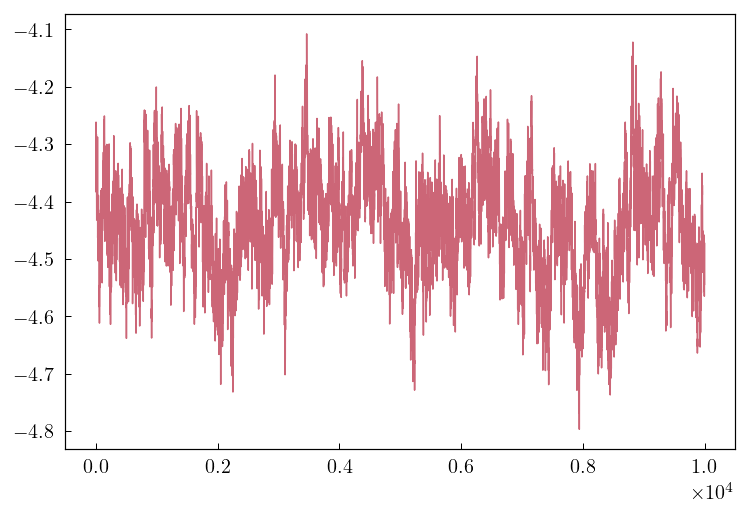

In [10]:
plt.plot(s4q)

# Old Anton trajectories

In [11]:
from joblib import Parallel, delayed
from multiprocessing import cpu_count
n_jobs = cpu_count()

In [12]:
dcdfiles = [f"/project/dinner/scguo/anton-old/civsd_{i}.dcd" for i in range(179)]

In [13]:
from MDAnalysis import transformations

In [14]:
def s4_disp_q(topfile, trajfile):
    """Compute the displacement charge contribution of 
    each sensing arginine"""
    u = mda.Universe(topfile, trajfile)
    no_prot = u.atoms
    trans = transformations.wrap(no_prot, compound='residues')
    center = transformations.center_in_box(no_prot, point=(0, 0, 0), wrap=True)
    u.trajectory.add_transformations(trans, center)
    
    s4q = np.empty(10000)
    sel = u.select_atoms("protein and resid 217 to 233 and backbone")
    for i, _ in enumerate(u.trajectory[:10000]):
        s4q[i] = compute_displacement_charge_sel(u, sel)
    return s4q

In [ ]:
rq_all = Parallel(n_jobs=n_jobs, verbose=40)(
    delayed(s4_disp_q)(topfile, f) for f in dcdfiles)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [26]:
len(rq_all), rq_all[0].shape

(179, (10000,))

In [27]:
rq = np.array(rq_all)
print(rq.shape)

(179, 10000)


In [28]:
np.save("../../data/raw_feat/displacement_q_s4_0-178.npy", rq_all)

## divide up protein

In [15]:
def disp_q_sel(topfile, trajfile, selstr):
    """Compute the displacement charge contribution of for a given selection"""
    u = mda.Universe(topfile, trajfile)
    no_prot = u.atoms
    trans = transformations.wrap(no_prot, compound='residues')
    center = transformations.center_in_box(no_prot, point=(0, 0, 0), wrap=True)
    u.trajectory.add_transformations(trans, center)
    
    dq = np.empty(10000)
    sel = u.select_atoms(selstr)
    for i, _ in enumerate(u.trajectory[:10000]):
        dq[i] = compute_displacement_charge_sel(u, sel)
    return dq

In [17]:
plt.hist(np.concatenate(rq_all), bins=20)

NameError: name 'rq_all' is not defined

In [16]:
from collections import OrderedDict

In [17]:
selections = OrderedDict()
for rid in [217, 223, 226, 229, 232]:
    selections[f'R{rid}'] = f"protein and resid {rid} and not backbone"
selections['D129'] = "protein and resid 129 and not backbone"
selections['D186'] = "protein and resid 186 and not backbone"
selections['E183'] = "protein and resid 183 and not backbone"
selections['S4'] = "protein and resid 214 to 240 and not (protein and resid 217 223 226 229 232 and not backbone)"
selections['S1S3'] = "protein and resid 1 to 213 and not (protein and resid 129 183 186 and not backbone)"
selections['water'] = "resname TIP3"
selections['ion'] = "resname CLA SOD"
selections['lipid'] = "resname POPC"

total = 0
for (key, selstr) in selections.items():
    sellen = len(u.select_atoms(selstr))
    print(key, sellen)
    total += sellen
print(total, len(u.atoms))

R217 20
R223 20
R226 20
R229 20
R232 20
D129 8
D186 8
E183 11
S4 359
S1S3 1706
water 31035
ion 39
lipid 23316
56582 56582


In [18]:
selections.keys()

odict_keys(['R217', 'R223', 'R226', 'R229', 'R232', 'D129', 'D186', 'E183', 'S4', 'S1S3', 'water', 'ion', 'lipid'])

In [19]:
def disp_q_sel(topfile, trajfile, selstr):
    """Compute the displacement charge contribution of for series of selection"""
    u = mda.Universe(topfile, trajfile)
    no_prot = u.atoms
    trans = transformations.wrap(no_prot, compound='residues')
    center = transformations.center_in_box(no_prot, point=(0, 0, 0), wrap=True)
    u.trajectory.add_transformations(trans, center)
    
    sel = u.select_atoms(selstr)
    dq = np.empty(10000)
    for i, _ in enumerate(u.trajectory[:10000]):
        dq[i] = compute_displacement_charge_sel(u, sel)
    return dq

In [23]:
def universe(topfile, trajfile):
    """Compute the displacement charge contribution of for series of selection"""
    u = mda.Universe(topfile, trajfile)
    no_prot = u.atoms
    trans = transformations.wrap(no_prot, compound='residues')
    center = transformations.center_in_box(no_prot, point=(0, 0, 0), wrap=True)
    u.trajectory.add_transformations(trans, center)
    return u


In [24]:
def disp_q_u(u, selstr):
    """Compute the displacement charge contribution of for series of selection"""
    sel = u.select_atoms(selstr)
    dq = np.empty(10000)
    for i, _ in enumerate(u.trajectory[:10000]):
        dq[i] = compute_displacement_charge_sel(u, sel)
    return dq

In [ ]:
dq_r217 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(disp_q_sel)(topfile, f, selections['R217']) for f in dcdfiles)

# np.save(f"../../data/raw_feat/displacement_q_{key}_0-178.npy", q_all)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` na

In [21]:
len(dq_r217)

179

In [25]:
np.save("../../data/raw_feat/displacement_q_r217", dq_r217)

In [26]:
universes = [universe(topfile, f) for f in dcdfiles]

In [ ]:
dq_r223 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(disp_q_u)(u, selections['R223']) for u in universes)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netc

In [28]:
len(dq_r223)

179

In [29]:
np.save("../../data/raw_feat/displacement_q_r223", dq_r223)

In [ ]:
dq_r226 = Parallel(n_jobs=24, verbose=20)(
    delayed(disp_q_u)(u, selections['R226']) for u in universes)

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netc

In [ ]:
np.save("../../data/raw_feat/displacement_q_r226", dq_r226)

In [ ]:
dq_r229 = Parallel(n_jobs=24, verbose=20)(
    delayed(disp_q_u)(u, selections['R229']) for u in universes)

In [ ]:
np.save("../../data/raw_feat/displacement_q_r229", dq_r229)

In [ ]:
len(dq_r226)